In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler
from sklearn.manifold import TSNE
# from jacobian import JacobianReg
from sklearn.cluster import KMeans

train_path = "/home/max/Desktop/galaxy_science_display/images_gz2/"

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
supervised_path = "/home/max/Desktop/galaxy_science_display/eight_type/train/"
# val_image_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/validation/"
# test_image_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/test/"
unsupervised_path = "/home/max/Desktop/galaxy_science_display/images_gz2/"
iter1_supervised_path = "/home/max/Desktop/eight_type/train/"
# supervised_path = "/home/max/Desktop/galaxy_science_display/eight_type/train/"
supervised_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/train"
val_image_path = "/home/max/Desktop/galaxy_science_display/eight_type/validation/"
test_image_path = "/home/max/Desktop/galaxy_science_display/eight_type/test/"


batch_size = 100
train_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(100, 100)),
                                  transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
                                  transforms.ToTensor()])
train_data = ImageFolder(supervised_path, transform=train_trans)
train_loader = DataLoader(train_data, pin_memory=True, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle = True)

unsuper_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
                                  transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(200, 200)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
#                                   transforms.RandomResizedCrop((224, 224)),
                                  transforms.ToTensor()])
unsuper_data = ImageFolder(unsupervised_path, transform=unsuper_trans)
unsuper_loader = DataLoader(unsuper_data, pin_memory=True, batch_size=batch_size, shuffle=True)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(1024, 1024, 3, padding=1)
        )
    def forward(self, x):
        return self.encoder(x)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(128,  64, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(64,  3, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32,  3, kernel_size=2, stride=2),
#             nn.Sigmoid()
        )
 
    def forward(self, x):
        encode = self.encoder(x)
        data = encode.flatten(1)
        output = self.decoder(encode)
        return encode, output, data

In [5]:
def plot_low_dim(low, lab):
    color = ['red', 'blue', 'black', 'orange', 'green', 'pink', 'purple', 'gray']
    plt.cla()
    for i in range(batch_size):
        plt.scatter(low[0][i][0], low[0][i][1], color=color[lab[0][i]])

In [6]:
model = torch.load('autoencoder_pretrain_new_version_EfFIGI_GZ2.pkl').to(device)
# model = AutoEncoder()

In [7]:
test_img, test_lab = next(iter(test_loader))
for i in np.arange(3):
    print(test_img[i])

tensor([[[0.1922, 0.2784, 0.2471,  ..., 0.0000, 0.1843, 0.0000],
         [0.0980, 0.2471, 0.0667,  ..., 0.0000, 0.2000, 0.1294],
         [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1882, 0.2353, 0.0039,  ..., 0.2392, 0.2235, 0.0000],
         [0.0000, 0.0000, 0.0471,  ..., 0.1137, 0.1255, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0824, 0.1843, 0.1529]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.1137, 0.0000, 0.2431],
         [0.1843, 0.0000, 0.0000,  ..., 0.1373, 0.0000, 0.1529],
         [0.1216, 0.2000, 0.1961,  ..., 0.1412, 0.1686, 0.0000],
         ...,
         [0.0863, 0.1529, 0.2510,  ..., 0.0000, 0.0000, 0.1608],
         [0.1843, 0.0588, 0.0118,  ..., 0.0000, 0.1765, 0.0980],
         [0.2235, 0.1216, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0824, 0.0000, 0.0000,  ..., 0.1098, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2039,  ..., 0.1608, 0.0000, 0.1020],
         [0.0000, 0.0000, 0.0039,  ..., 0.2471, 0.1843, 0.

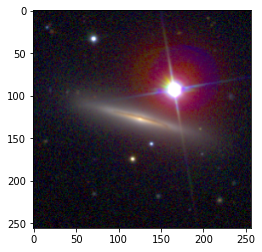

/home/max/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


autoencoder:


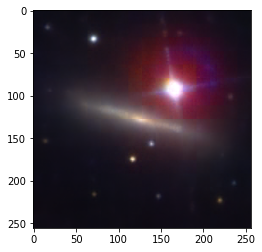

In [8]:
img_list = ['E/PGC0034780.png', 'Sc/PGC0032570.png', 'S0/PGC0035126.png', 'Sa/PGC0049415.png', 'Sb/PGC0051100.png', 'SBa/PGC0039699.png', 'SBb/PGC0047915.png', 'SBc/PGC0044125.png']
loader = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/train/" + img_list[5]
img = Image.open(path).convert('RGB')
image_ori = loader(img).squeeze(0)
plt.imshow(image_ori.permute(1, 2, 0))
plt.show()
image = loader(img).unsqueeze(0)
# print(image.shape)
image = image.to(device)
codes, output, data1 = model(image)
print("autoencoder:")
plt.imshow(output.squeeze().to('cpu').permute(1, 2, 0).detach().numpy())
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 5.658394
[t-SNE] KL divergence after 250 iterations with early exaggeration: 155.666748
[t-SNE] KL divergence after 8000 iterations: 1.196574


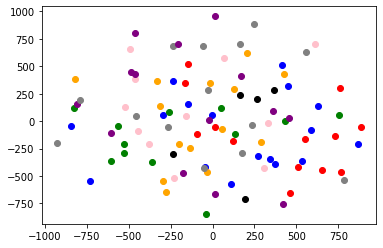

In [9]:
# for test_img, test_lab in tqdm(test_loader):
test_img = test_img.to(device)
out, last, data1 = model(test_img)
out, last, data1 = out.squeeze().cpu(), last.cpu(), data1.squeeze().cpu()
# print(out.shape)
# print(last.shape)
# print(test_lab)
# print(out[0])

# print(data1.shape)
low = []
label = []
tsne = TSNE(n_components=3, perplexity=30, init='random', random_state=5, verbose=1, n_iter=8000)
low_dim = tsne.fit_transform(data1.data.numpy())
kmeans = KMeans(n_clusters=8, random_state=0).fit(low_dim)
low.append(low_dim.tolist())
lab = test_lab.numpy().tolist()
label.append(lab)

plot_low_dim(low, label)

# plt.scatter(out[:, 0].detach().numpy(), out[:, 1].detach().numpy(), c=test_lab)
# plt.colorbar()
# plt.show()

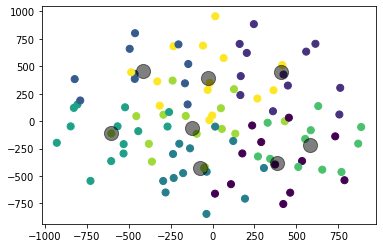

In [10]:
y_kmeans = kmeans.predict(low_dim)
plt.scatter(low_dim[:, 0], low_dim[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [11]:
print(y_kmeans)

[1 7 4 3 6 5 0 1 7 7 7 6 3 4 1 1 2 0 4 6 0 4 4 1 5 7 6 6 3 5 5 6 7 3 1 7 0
 5 3 6 2 7 3 4 0 6 0 7 5 3 6 4 0 7 5 3 6 1 7 6 2 2 2 3 7 5 4 1 0 0 6 7 6 5
 2 3 0 2 3 4 5 1 0 4 5 4 1 6 1 2 3 2 3 6 4 4 1 0 2 7]


In [12]:
print(label[0])

[2, 3, 5, 4, 1, 1, 1, 1, 5, 3, 1, 0, 2, 1, 4, 0, 6, 0, 4, 4, 6, 4, 6, 6, 1, 2, 6, 7, 3, 0, 0, 3, 3, 0, 7, 2, 1, 1, 2, 1, 5, 7, 5, 5, 7, 5, 0, 6, 1, 3, 5, 4, 6, 7, 0, 3, 4, 7, 7, 1, 5, 0, 1, 3, 1, 5, 4, 3, 7, 3, 7, 6, 4, 0, 7, 0, 1, 6, 3, 1, 1, 7, 7, 4, 0, 4, 3, 4, 5, 3, 5, 6, 6, 3, 7, 7, 6, 6, 0, 6]


In [13]:
cnt = 0
for i in range(70):
    if y_kmeans[i] == label[0][i]:
        cnt+=1
print(f'k-means accuracy: {(cnt/70) * 100:.2f}%')
print(cnt)

k-means accuracy: 22.86%
16
